In [10]:
# Import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
from datetime import datetime

In [11]:
# Import the csv file
CSV_DIR = os.path.join('..', '..', 'data', 'csv')
input_file = os.path.join(CSV_DIR, 'measurements_amsterdam.csv')
df = pd.read_csv(input_file, sep=';')

In [12]:
# Remove columns that are not needed
df = df.drop(columns=['location', 'latitude', 'longitude', 'altitude'])

# Rename column day to date
df = df.rename(columns={'day': 'date'})

In [13]:
# Number of rows and columns
df.shape

(18850, 10)

In [14]:
# Convert strings into floats and datetimes
float_column_names = [f'{temp}_{agg}' for temp in ['temperature', 'feels_like_temperature'] for agg in
                      ['avg', 'min', 'max']] + ['wind_speed', 'precipitation', 'precipitation_duration']
for field in float_column_names:
    df[field] = df[field].astype(float)
df['date'] = pd.to_datetime(df['date'])

In [15]:
# Split date into year, month and day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear

In [16]:
# Column names
list(df.columns)

['date',
 'temperature_avg',
 'temperature_min',
 'temperature_max',
 'feels_like_temperature_avg',
 'feels_like_temperature_min',
 'feels_like_temperature_max',
 'wind_speed',
 'precipitation',
 'precipitation_duration',
 'year',
 'month',
 'day',
 'day_of_year']

In [17]:
print(df.head())

        date  temperature_avg  temperature_min  temperature_max  \
0 2023-04-21             10.8              7.9             15.8   
1 2023-04-20              8.8              6.8             11.0   
2 2023-04-19             10.6              7.9             13.9   
3 2023-04-18              9.7              6.8             13.0   
4 2023-04-17              9.7              7.2             14.0   

   feels_like_temperature_avg  feels_like_temperature_min  \
0                         9.7                         5.3   
1                         6.3                         2.8   
2                         8.8                         4.4   
3                         7.9                         2.6   
4                         8.2                         4.7   

   feels_like_temperature_max  wind_speed  precipitation  \
0                        15.8        19.9            7.3   
1                        11.0        32.0            0.7   
2                        13.9        34.7         

In [18]:
def plot_per_year(df: pd.DataFrame, field: str, aggregation: str, title: str, ylabel: str):
    # Exclude the first and last year of the dataset
    first_year = df['year'].min()
    last_year = df['year'].max()
    df_with_complete_years_only = df[(df['year'] > first_year) & (df['year'] < last_year)]
    
    # Apply the aggregation
    if aggregation == 'mean':
        df_agg = df_with_complete_years_only.groupby('year')[field].mean().reset_index()
    elif aggregation == 'sum':
        df_agg = df_with_complete_years_only.groupby('year')[field].sum().reset_index()
    else:
        raise ValueError(f'Aggregation {aggregation} is not supported')

    # Calculate the slope and intercept of the linear trendline
    x = df_agg['year']
    y = df_agg[field]
    slope, intercept = np.polyfit(x, y, 1)
    
    # Plot the temperature per year along with the trendline
    fig, ax = plt.subplots()
    ax.plot(x, y, label=ylabel)
    ax.plot(x, slope*x + intercept, color='red', label='Linear trendline')
    ax.legend()
    
    # Set x-ticks to be the even years
    ax.set_xticks(np.arange(first_year, last_year + 1, 2))
    
    # Set labels
    ax.set_xlabel('Year')
    if 'temperature' in field:
        ax.set_ylabel('Temperature (°C)')
    elif field == 'precipitation':
        ax.set_ylabel('Precipitation (mm)')
    elif field == 'precipitation_duration':
        ax.set_ylabel('Precipitation duration (hours)')
    elif field == 'wind_speed':
        ax.set_ylabel('Wind speed (m/s)')
    else:
        ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Show the plot
    plt.show()

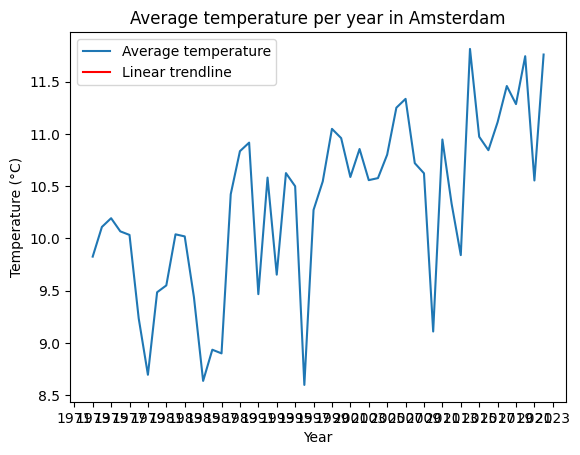

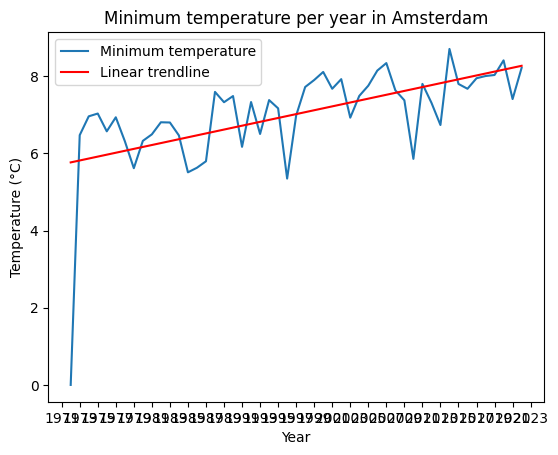

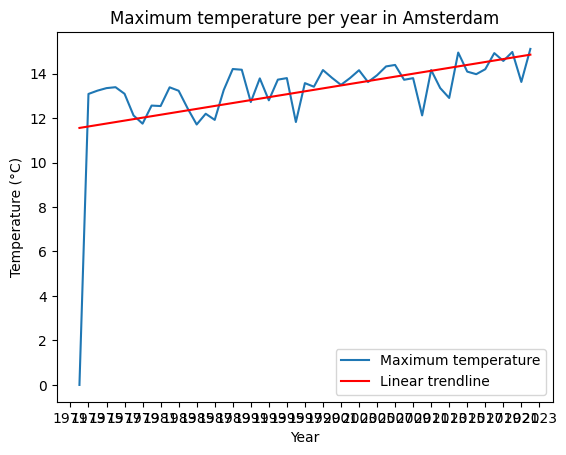

In [19]:
plot_per_year(df, 'temperature_avg', 'mean', 'Average temperature per year in Amsterdam', 'Average temperature')
plot_per_year(df, 'temperature_min', 'mean', 'Minimum temperature per year in Amsterdam', 'Minimum temperature')
plot_per_year(df, 'temperature_max', 'mean', 'Maximum temperature per year in Amsterdam', 'Maximum temperature')

Something seems to be wrong with the precipitation duration data. It is stable around 500 hours per year from 2002 to 2014, but then jumps up to 2,000 hours.

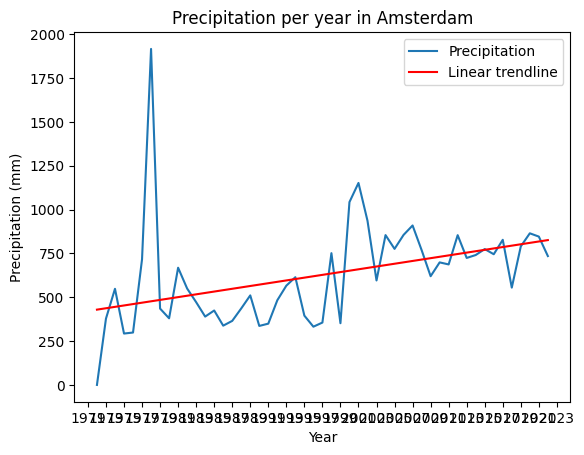

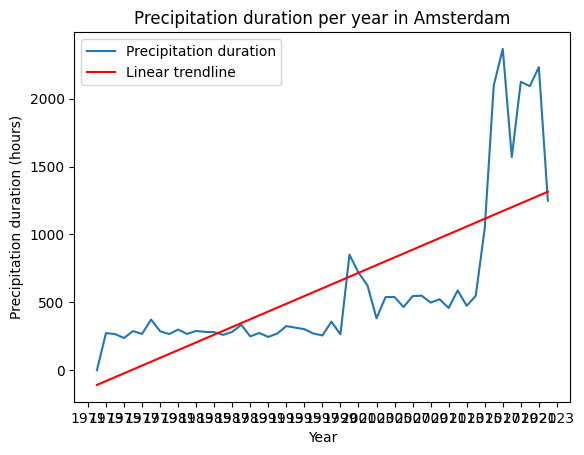

In [20]:
plot_per_year(df, 'precipitation', 'sum', 'Precipitation per year in Amsterdam', 'Precipitation')
plot_per_year(df, 'precipitation_duration', 'sum', 'Precipitation duration per year in Amsterdam', 'Precipitation duration')

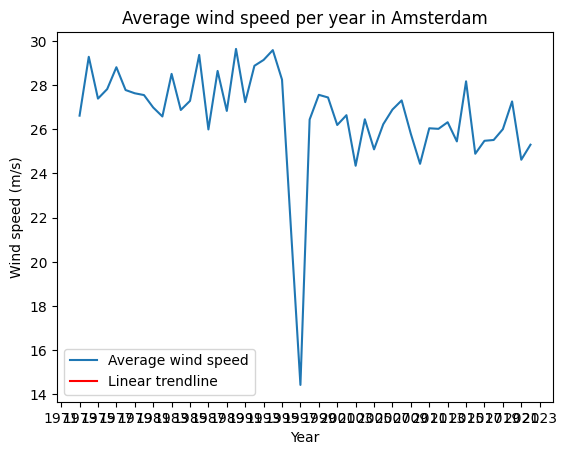

In [21]:
plot_per_year(df, 'wind_speed', 'mean', 'Average wind speed per year in Amsterdam', 'Average wind speed')

In [22]:
# Reshape the precipitation_duration data as a pivot table, and export it as a csv

# Create a pivot table with the mean precipitation duration per day of year and year
pivot = pd.pivot_table(df, values='precipitation_duration', index='day_of_year', columns='year', aggfunc='mean')

# Export as csv
output_file = os.path.join(CSV_DIR, 'precipitation_duration.csv')
pivot.to_csv(output_file)

print(pivot)

year         1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  ...  \
day_of_year                                                              ...   
1             NaN   0.0   0.0   0.0   1.0   1.0   2.0   1.0   2.0   2.0  ...   
2             NaN   0.0   0.0   0.0   0.0   2.0   1.0   1.0   1.0   1.0  ...   
3             NaN   0.0   0.0   0.0   0.0   1.0   1.0   2.0   1.0   0.0  ...   
4             NaN   0.0   1.0   1.0   1.0   1.0   1.0   2.0   0.0   2.0  ...   
5             NaN   0.0   1.0   0.0   1.0   2.0   0.0   2.0   0.0   0.0  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
362           0.0   0.0   2.0   0.0   0.0   2.0   2.0   2.0   2.0   1.0  ...   
363           0.0   0.0   0.0   0.0   0.0   1.0   2.0   2.0   2.0   0.0  ...   
364           0.0   0.0   0.0   1.0   0.0   2.0   3.0   1.0   2.0   1.0  ...   
365           0.0   0.0   0.0   0.0   1.0   0.0   2.0   2.0   1.0   0.0  ...   
366           NaN   0.0   NaN   NaN   Na

The first day in the dataset with a precipitation duration > 4 is in 2015. This looks incorrect to me. I have submitted a support request to Visual Crossing about this. Until that time, consider that column to be not trustworthy.

In [23]:
# Earliest date with precipitation_duration > 4:
subset_df = df.loc[:, ['date', 'precipitation_duration']]
filtered_df = subset_df[subset_df['precipitation_duration'] > 4]
filtered_df['date'].min()

Timestamp('2015-02-20 00:00:00')

In [24]:
# Find per year the last day in spring with a temperature below 0 degrees Celsius
df['is_spring'] = (df['month'].isin([1, 2, 3, 4, 5, 6]))
df['is_below_0'] = (df['temperature_min'] < 0)
df_spring = df[df['is_spring']]
df_spring = df_spring[df_spring['is_below_0']]
df_spring = df_spring.groupby('year')['date'].max().reset_index()
df_spring = df_spring.rename(columns={'date': 'last_spring_day_below_0'})
print(df_spring)

    year last_spring_day_below_0
0   1973              1973-06-08
1   1974              1974-03-13
2   1975              1975-03-31
3   1976              1976-05-01
4   1977              1977-04-20
5   1978              1978-04-15
6   1979              1979-04-19
7   1980              1980-04-23
8   1981              1981-05-03
9   1982              1982-04-14
10  1983              1983-04-04
11  1984              1984-04-11
12  1985              1985-04-24
13  1986              1986-04-13
14  1987              1987-03-22
15  1988              1988-04-26
16  1989              1989-03-18
17  1990              1990-04-10
18  1991              1991-04-24
19  1992              1992-02-20
20  1993              1993-04-03
21  1994              1994-04-10
22  1995              1995-03-30
23  1996              1996-04-13
24  1997              1997-04-23
25  1998              1998-03-24
26  1999              1999-03-11
27  2000              2000-04-08
28  2001              2001-04-22
29  2002  

In [25]:
# Date with the earliest and latest spring day below 0 degrees Celsius
earliest_day = None  # Variable to keep track of the earliest day, with a fixed year for easy comparison
earliest_date = None  # Variable with the actual date with the earliest day
latest_day = None
latest_date = None
for _index, row in df_spring.iterrows():
    dt = row['last_spring_day_below_0']
    dt = datetime(2000, dt.month, dt.day)
    if earliest_day is None or dt < earliest_day:
        earliest_day = dt
        earliest_date = row['last_spring_day_below_0']
    if latest_day is None or dt > latest_day:
        latest_day = dt
        latest_date = row['last_spring_day_below_0']
print(f'{latest_date=:%Y-%m-%d}, {earliest_date=:%Y-%m-%d}')

latest_date=1973-06-08, earliest_date=2014-01-31


In [57]:
# Filter out data from 2023
df = df[df['year'] < 2023]

# Average temperature between 1973 and 2000
df_1973_2000 = df[(df['year'] >= 1973) & (df['year'] <= 2000)]
avg_1973_2000 = df_1973_2000['temperature_avg'].mean()

# Offset all measurements by this average
df['temperature_avg'] = df['temperature_avg'] - avg_1973_2000

# Plot average temperature per year as bar chart
df.groupby('year')['temperature_avg'].mean().reset_index().plot.bar(x='year', y='temperature_avg')

# Show horizontal tick every 5 years
plt.xticks(np.arange(-1, 55, 5))

# Vertical axis title: Temperature w.r.t. 1973-2000 average (°C)
plt.ylabel('Temperature w.r.t. 1973-2000 average (°C)')

# Remove legend
plt.legend().remove()

# Chart title: Average temperature per year in Amsterdam
plt.title('Average temperature per year in Amsterdam')

# Make the background of the entire figure black, and the lettering white
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'

# Make the axes themselves white
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()